Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


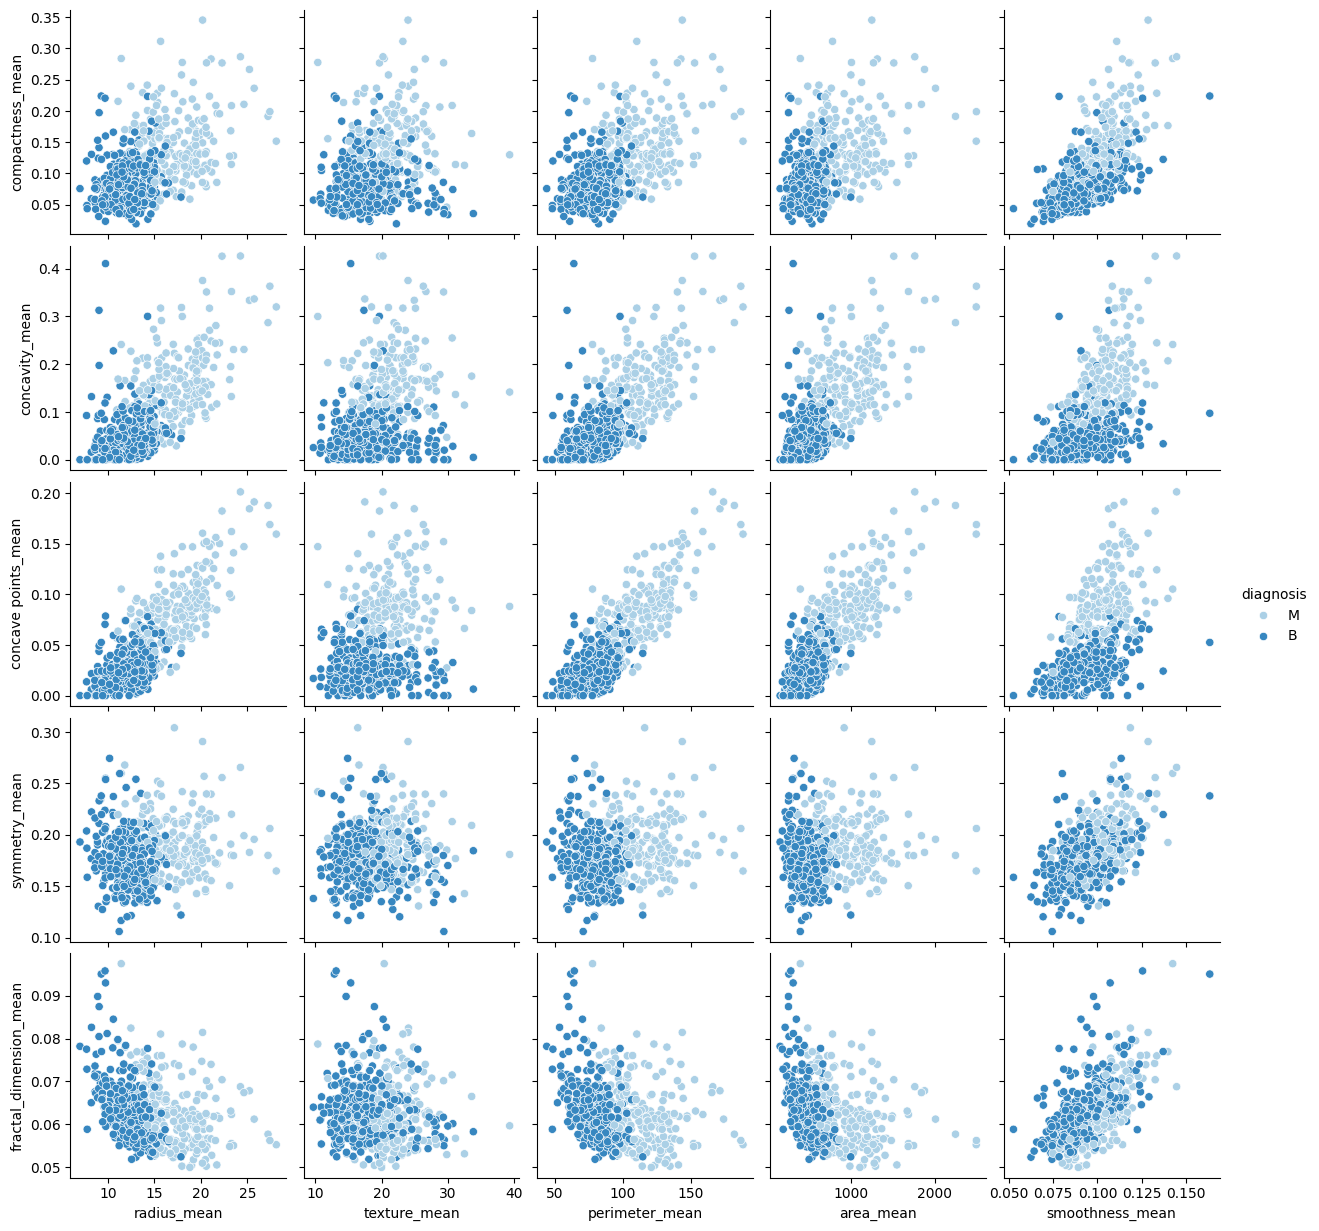

In [ ]:
from google.colab import drive
import pandas as pd
import os
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import warnings
from sklearn.exceptions import FitFailedWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

dataset = pd.read_csv("/content/drive/MyDrive/CAC/Breast_Cancer_Data.csv")

Labels = dataset['diagnosis']
Features = dataset[['radius_mean',	'texture_mean',	'perimeter_mean',	'area_mean'	, 'smoothness_mean' ,	'compactness_mean' ,	'concavity_mean' ,	'concave points_mean',	'symmetry_mean',	'fractal_dimension_mean']]
train1, test1, train2, test2 = train_test_split(Features, Labels, test_size=.2, shuffle=True)

X = dataset[['radius_mean',	'texture_mean',	'perimeter_mean',	'area_mean'	, 'smoothness_mean']]
Y = dataset[['compactness_mean' ,	'concavity_mean' ,	'concave points_mean',	'symmetry_mean',	'fractal_dimension_mean']]
sns.pairplot(dataset, x_vars = X, y_vars = Y, hue = 'diagnosis', palette = 'Blues', kind = 'scatter')

Num_Pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# String_Pipeline = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

Preprocessor = ColumnTransformer(
    transformers=[
        ('num', Num_Pipeline, ['radius_mean',	'texture_mean',	'perimeter_mean',	'area_mean'	, 'smoothness_mean' ,	'compactness_mean' ,	'concavity_mean' ,	'concave points_mean',	'symmetry_mean',	'fractal_dimension_mean'])
        # ('cat', String_Pipeline, [])
    ])


classifiers = {
    'DecisionTree': (DecisionTreeClassifier(), {
        'max_depth': [10, 20, 30],
        'criterion' : ['gini', 'entropy'],
        'min_samples_split' : [2,3,4,5,6,7,8],
        'random_state' : [0,10,20,30,40,50,60,70,80]
    }),
    'RandomForest': (RandomForestClassifier(), {
        'n_estimators': [100, 150, 200, 250, 300],
        'max_depth': [10, 20, 30],
        'criterion' : ['gini', 'entropy'],
        'min_samples_split' : [2,3,4,5,6,7,8]
    }),
    'LogisticRegression': (LogisticRegression(), {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [100, 200, 300],
        'l1_ratio': [0.5, 0.7]
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [1,2,3,4,5,6,7,8,9,10],
        'weights': ['uniform', 'distance'],
        'algorithm': ['brute', 'auto', 'ball_tree', 'kd_tree']
    })
}
test_score = 0
Classifier_Profile = None

for name, (clf, param_grid) in classifiers.items():
    grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(train1, train2)

    if grid_search.best_score_ > test_score:
        test_score = grid_search.best_score_
        Classifier_Profile = {
            'classifier': name,
            'score': grid_search.best_score_,
            'params': grid_search.best_params_,
            'estimator': grid_search.best_estimator_
        }

In [ ]:
Final_Classifier= Classifier_Profile['estimator']
Final_params = Classifier_Profile['params']

Final_Classifier = Pipeline(steps=[
    ('preprocessor', Preprocessor),
    ('classifier', Final_Classifier.set_params(**Final_params))
])


model = GridSearchCV(estimator=Final_Classifier, param_grid={}, cv=20)
model.fit(train1, train2)

pred_array = model.predict(test1)
print(accuracy_score(test2, pred_array))
print(classification_report(test2, pred_array))

0.9122807017543859
              precision    recall  f1-score   support

           B       0.92      0.95      0.94        76
           M       0.89      0.84      0.86        38

    accuracy                           0.91       114
   macro avg       0.91      0.89      0.90       114
weighted avg       0.91      0.91      0.91       114



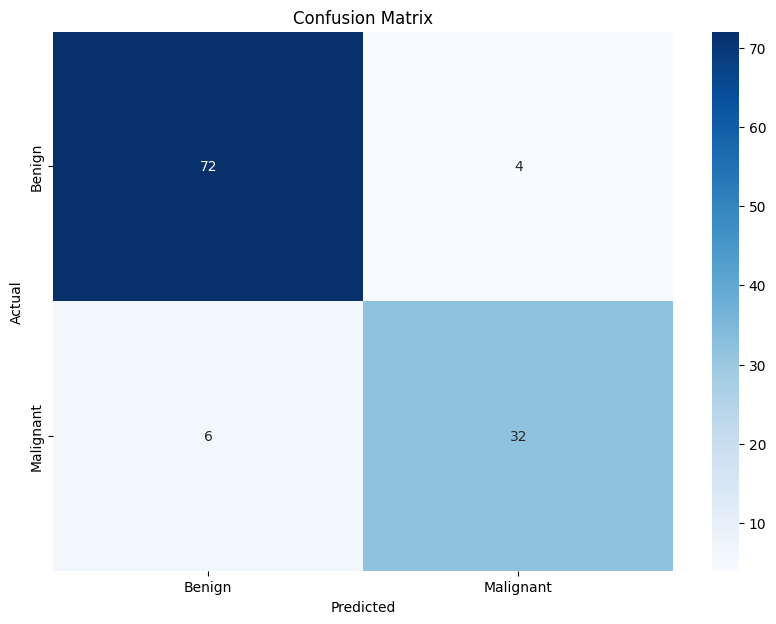

In [ ]:
conf_matrix = confusion_matrix(test2, pred_array)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()